In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import os

import itertools
import datetime

def flatten_list(list_a):
    return list(itertools.chain(*list_a))

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response



In [2]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def deterministic_transition(var, rate, dt=1):
    return var*dt*rate

def model(x, beta, gamma, report_rate=0.3, N=1e6, dt=1):
    S = x[0]
    I = x[1]
    R = x[2]

    foi   =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, dt*foi)   # susceptible to exposed
    i2r     =  b_transition(I, dt*gamma) # exposed to infected reported.

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r # Infected Reported
    R    = R   + i2r       # Recovered
    C    = np.random.binomial(s2i, report_rate) # Assume total infections are not completely ascertained.


    return [S, I, R, C]


In [3]:
priors_range_dict  = {}
priors_range_dict["beta"]  = [0.2, 1]    # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3] # Recovery rate range

pop = 1e6
num_days = 100
x  = [pop-0.01*pop, 0.01*pop, 0, 0]

x_sol      = np.zeros((num_days, 4))
gamma_truth = 1/7
beta_truth  = 3.5 * gamma_truth

x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, N=pop)

x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"
dates = x_sol_df.index.values


In [4]:
def negative_binomial_loglikelihood(real_world_observations, model_observations, particle_dispersion=0.5):
    # Assume probability particle distribution is in the second dimension
    # Γ(r + y)p**r(1 − p)y) − ln (Γ(r)Γ(y + 1)


    # Assume log-likelihood is a negative binomial dist
    ll =  np.sum(np.log(np.random.gamma(real_world_observations+model_observations+1)) + model_observations*np.log(1-particle_dispersion) - np.log(np.random.gamma(real_world_observations+1)), 1)

    return ll

def poisson_loglikelihood(real_world_observations, model_observations, num_times=100):
    nll =  -np.sum(model_observations,1) + np.sum(real_world_observations*np.log(model_observations+1),1) # Poisson LL
    return - nll

def normal_loglikelihood(real_world_observations, model_observations, error_variance=None, A=0.1, num_times=100):
    if not error_variance:
        error_variance = 1+(0.2*real_world_observations)**2

    nll =  A * np.exp(-0.5 * (real_world_observations-model_observations)**2/error_variance) # Normal LL
    return - nll

def normalize_weights(weights):
    return weights / np.sum(weights)

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )


# Particle Filter with importance sampling

In [5]:

obs_world_df = x_sol_df[["C"]]

num_particles = 1e4


num_particles = int(1e4)

particles_prior = sample_params_uniform(priors_range_dict, num_ensembles=num_particles)
weigths         = np.zeros((1, num_particles))

# Init state space for all particles
x_init = np.array([[pop-0.01*pop, 0.01*pop, 0, 0]]).T * np.ones((1, num_particles))
x = x_init
weights = np.ones((num_particles)) / num_particles
num_vars = 4
num_steps = len(dates)

weigths_all      = np.full((num_particles, num_steps), np.nan)
weigths_all[:,0] = weights

obs = np.full((num_particles, len(dates)-1), np.nan)

# PARTICLE FILTER WITH IMPORTANCE SAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    # Integrate all particles.
    x_ens = np.full((num_vars,num_particles), np.nan)
    for idx_ens in range(num_particles):
        beta   = particles_prior[0, idx_ens]
        gamma  = particles_prior[1, idx_ens]

        x_ens[:,idx_ens] = model(x[:,idx_ens], beta, gamma, N=pop)

    x = x_ens.copy()

    # Compute weights
    obs_time  = obs_world_df.loc[:date]["C"].values[1:]      # World observations
    model_obs = np.expand_dims(x_ens[-1, :], 0)  # Model observations
    obs[:,idx_date] = model_obs

    # compute likelihood and normalize it
    ll_tot = poisson_loglikelihood( np.expand_dims(obs_time, -1).T, obs[:,:idx_date+1])
    ll_this = poisson_loglikelihood( np.expand_dims(obs_time[idx_date], -1).T, model_obs)

    weights = weigths_all[:,idx_date] * ll_tot
    #weights = ll

    weights = normalize_weights(weights)

    # Resampling new particles
    weigths_all[:,idx_date+1] = weights


99it [00:15,  6.30it/s]


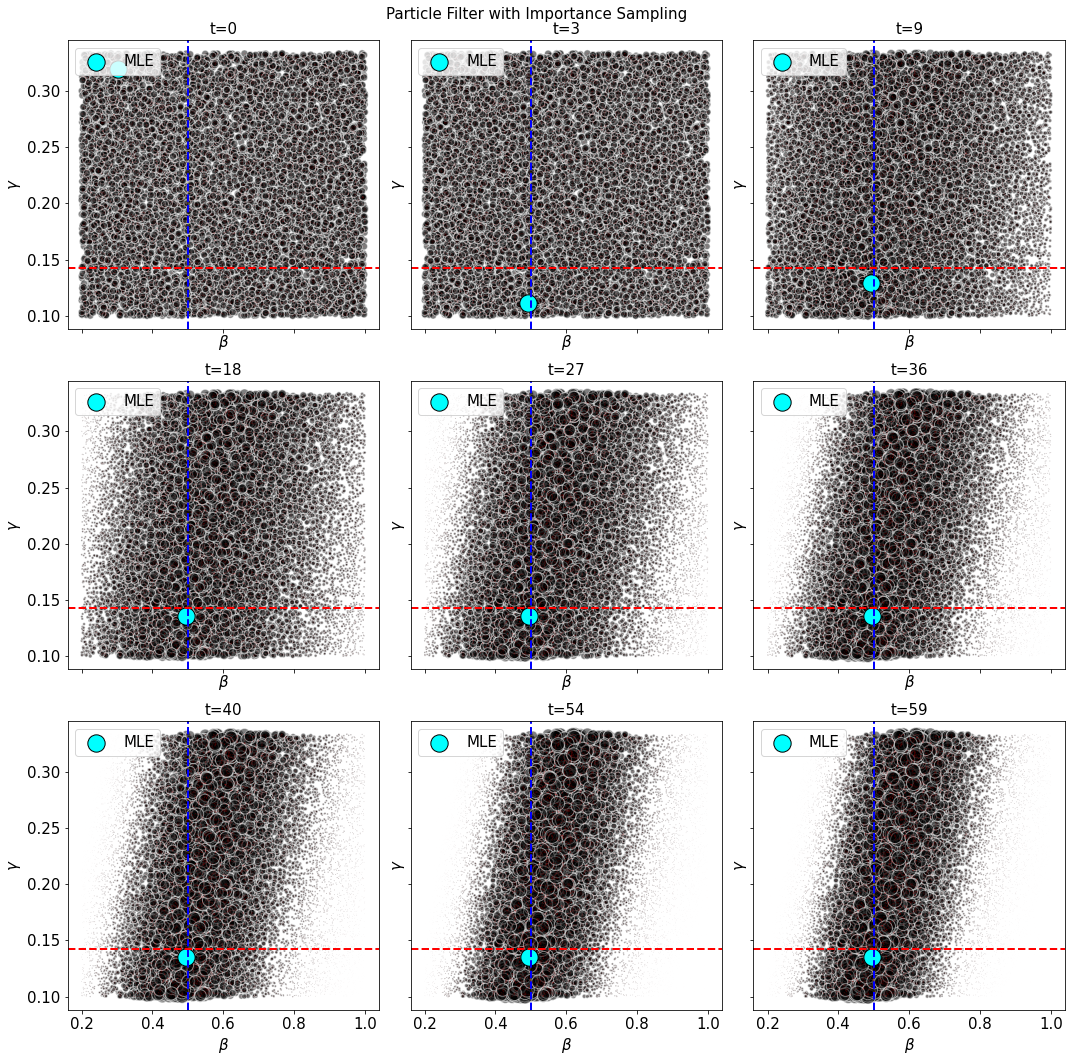

In [6]:
# Plot particle convergence just for ploting
particles_convergence = [0, 3, 9,
                        18, 27, 36,
                        40, 54, 59]

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for idx, axi in enumerate(ax.flatten()):
    sizes = num_particles*weigths_all[:,particles_convergence[idx]]

    idx_none = np.where(sizes<1e-6)[0]
    sizes[idx_none] = None

    axi.scatter(particles_prior[0,:], particles_prior[1,:], edgecolor="w", facecolor="k", s=50*sizes, alpha=0.5)
    axi.scatter(particles_prior[0,:], particles_prior[1,:], edgecolor="red", facecolor="red", s=20*sizes/num_particles)

    particles_best_time = particles_prior[:,weigths_all[:,particles_convergence[idx]].argmax()]
    axi.scatter(particles_best_time[0], particles_best_time[1], edgecolor="k", facecolor="cyan", s=300, label="MLE")


    axi.set_title(f"t={particles_convergence[idx]}", fontsize=15)
    axi.axvline(x=beta_truth, color="blue", lw=2, linestyle="--")
    axi.axhline(y=gamma_truth, color="r", lw=2, linestyle="--")
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.set_ylabel(r"$\gamma$", fontsize=15)
    axi.set_xlabel(r"$\beta$", fontsize=15)
    axi.legend(fontsize=15)

fig.suptitle("Particle Filter with Importance Sampling", fontsize=15)
plt.tight_layout()


In [7]:
particles_best = np.argmax(weigths_all[:,-1])
beta_best  = particles_prior[0, particles_best]
gamma_best = particles_prior[1, particles_best]

# Simulate the model with best estimated parameters

pop = 1e6
num_days = 100
x  = [pop-0.01*pop, 0.01*pop, 0, 0]

num_iters =  num_particles

x_mle_df = pd.DataFrame(columns=["S", "I", "R", "C", "iter_idx"])

x_sol          = np.zeros((4, num_days, int(num_iters)))
x_sol[ :, 0, :] = np.expand_dims(x, -1) * np.ones((1, int(num_iters)))

# PARTICLE FILTER WITH IMPORTANCE SAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    particles_post = particles_prior.copy()
    # Integrate all particles.
    for idx_ens in range(num_particles):
        beta   = particles_prior[0, particles_best]
        gamma  = particles_prior[1, particles_best]

        x_sol[:, idx_date+1, idx_ens] = model(x_sol[:, idx_date, idx_ens], beta_best, gamma_best, N=1e6)




99it [00:15,  6.30it/s]


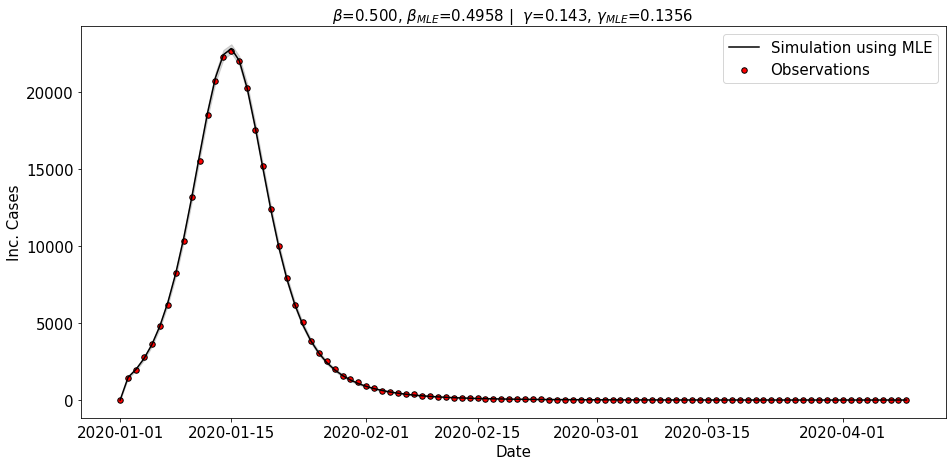

In [8]:
x_mle_df = pd.DataFrame(x_sol.T.reshape(len(dates) * num_particles, 4),columns=["S", "I", "R", "C"])

x_mle_df["date"]     = list(range(len(dates)))*num_iters
x_mle_df["iter_idx"] = flatten_list([[d]*len(dates) for d in list(range(num_iters)) ])
x_mle_df = x_mle_df.sort_values(by=[ "iter_idx", "date"])

sus_df = create_df_response(x_sol[0,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inf_df = create_df_response(x_sol[1,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
rec_df = create_df_response(x_sol[2,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inc_df = create_df_response(x_sol[3,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

#for par_idx in range(num_particles):
#    ax.plot(inc_df.index.values, x_sol[-1,:,par_idx], color="green", alpha=0.3)

ax.plot(inc_df.index.values, inc_df["mean"], color="k", label="Simulation using MLE")
ax.fill_between(inc_df.index.values, inc_df["low_95"], inc_df["high_95"], color="gray", alpha=0.3)

ax.scatter(inc_df.index.values, x_sol_df["C"], edgecolor="k", facecolor="red", label="Observations", s=30)
ax.tick_params( which='both', axis='both', labelsize=15)
ax.set_ylabel("Inc. Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_title(r"$\beta$={:0.3f}, $\beta_{{MLE}}$={:0.4f} |  $\gamma$={:0.3f}, $\gamma_{{MLE}}$={:0.4f} ".format(beta_truth, beta_best, gamma_truth, gamma_best), fontsize=15)
ax.legend(fontsize=15)



# Particle filter with Resampling
Implement resample Algorithm as in Arulampalam et. al.
            *** A tutorial on particle filters for online nonlinear/non-Gaussian Bayesian tracking ***

The only difference is that I add another parameter to the resample algorithm, a fixed (or variable 🤷) fraction of particles to be resample. This controls the number of particles "lost" in each assimilation step. This helps improving the "degenerance" in the effective sample size after few iterations of the PF.


In [9]:
def compute_effective_sample_size(weights):
    return 1/np.sum(weights**2)

def importance_sampling(weights, world_observations, model_observations, importance_density):
    # Compute loglieklihood using the given importance density.
    loglik  = importance_density(world_observations , model_observations)

    # Recompute weights and normalize them
    weights = weights * loglik
    weights = normalize_weights(weights)

    return weights

def resample_particles(particles, weights, num_particles):
    """ Resample Algorithm as in Arulampalam et. al.
            *** A tutorial on particle filters for online nonlinear/non-Gaussian Bayesian tracking ***


    Args:
        particles ([type]): [Numpy array with the particles]
        weights ([type]): [Numpy array with the weights of the particles]
    """
    # sort weights and compute CDF

    arg_sorted_weights = np.argsort(weights)
    cdf_w_t = np.cumsum(weights[arg_sorted_weights])

    # sort weights and particles
    weights   = weights[arg_sorted_weights]
    particles = particles[:, arg_sorted_weights]

    proposal = np.random.uniform(0, 1/num_particles)

    i = 0

    replace_particle_dict = {}
    for j in range(num_particles):
        uj = proposal + 1/num_particles*(j)
        while uj > cdf_w_t[i]:
            i += 1
        replace_particle_dict[j] = i

    particles_index = list(range(num_particles))
    particles_index = np.vectorize(replace_particle_dict.get)(particles_index)

    particles                                              = particles[:, particles_index]
    weights[particles_index != np.arange(num_particles)]   = 1/num_particles # Replace weights of particles that changed

    return particles, weights, particles_index

def resample_particles2(particles, x_state, obs, weights, num_particles, prop_particle_to_replace=None):

    if prop_particle_to_replace:
        fixed_particles = np.sort(np.random.choice(np.arange(num_particles), size=int(num_particles*(1-prop_particle_to_replace)), replace=False, p=weights))
        particles_index = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles_index[fixed_particles] = fixed_particles
    else:

        particles_index = np.sort(np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights))

    # This is what Arulampalam et. al suggest ... (I do not agree, but it works :)! )
    weights = np.ones(num_particles)*1/num_particles

    particles             = particles[:, particles_index] # Replace particles.
    x_state               = x_state[:, particles_index]
    obs                   = obs[:, particles_index]

    return particles, x_state, obs, weights, particles_index


In [15]:

obs_world_df = x_sol_df[["C"]]

num_particles = 1e4

num_particles = int(1e4)

particles_prior = sample_params_uniform(priors_range_dict, num_ensembles=num_particles)
weigths         = np.zeros((1, num_particles))

# Init state space for all particles
x_init = np.array([[pop-0.01*pop, 0.01*pop, 0, 0]]).T * np.ones((1, num_particles))
x = x_init
weights = np.ones((num_particles)) / num_particles
num_vars = 4
num_steps = len(dates)

weigths_all      = np.full((num_particles, num_steps), np.nan)
weigths_all[:,0] = weights

obs                = np.full( (len(dates)-1, num_particles), np.nan)
particles_post_all = np.full((2, num_particles, len(dates)), np.nan)
particles_post_all[:, :, 0] = particles_prior
n_eff                       = np.full((len(dates)), np.nan)

# PARTICLE FILTER WITH IMPORTANCE SAMPLING + RESAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    # Integrate all particles.
    x_ens = np.full((num_vars,num_particles), np.nan)
    for idx_ens in range(num_particles):
        beta   = particles_prior[0, idx_ens]
        gamma  = particles_prior[1, idx_ens]

        x_ens[:,idx_ens] = model(x[:,idx_ens], beta, gamma, N=pop)

    x = x_ens.copy()

    # Compute weights
    obs_time  = obs_world_df.loc[:date]["C"].values[1:]      # World observations
    model_obs = np.expand_dims(x_ens[-1, :], 0)  # Model observations
    obs[idx_date, :] = model_obs


    # Update weights using importance density
    weights = importance_sampling(weigths_all[:,idx_date], np.expand_dims(obs_time, -1).T, obs[:idx_date+1,:].T, poisson_loglikelihood)

    # Compute effective sample size
    n_eff[idx_date] = compute_effective_sample_size(weights)

    particles_post, x_post, obs_post, weights, particles_index = resample_particles2(particles_prior, x, obs, weights, num_particles, prop_particle_to_replace=0.1)
    particles_prior = particles_post.copy()
    x               = x_post.copy()
    obs               = obs_post.copy()

    # Update weights using importance density after resampling
    weights                              = importance_sampling(weights, np.expand_dims(obs_time, -1).T, obs[:idx_date+1,:].T, poisson_loglikelihood)
    weigths_all[:,idx_date+1]            = weights

    particles_post_all[:, :, idx_date+1] = particles_post


99it [00:17,  5.64it/s]


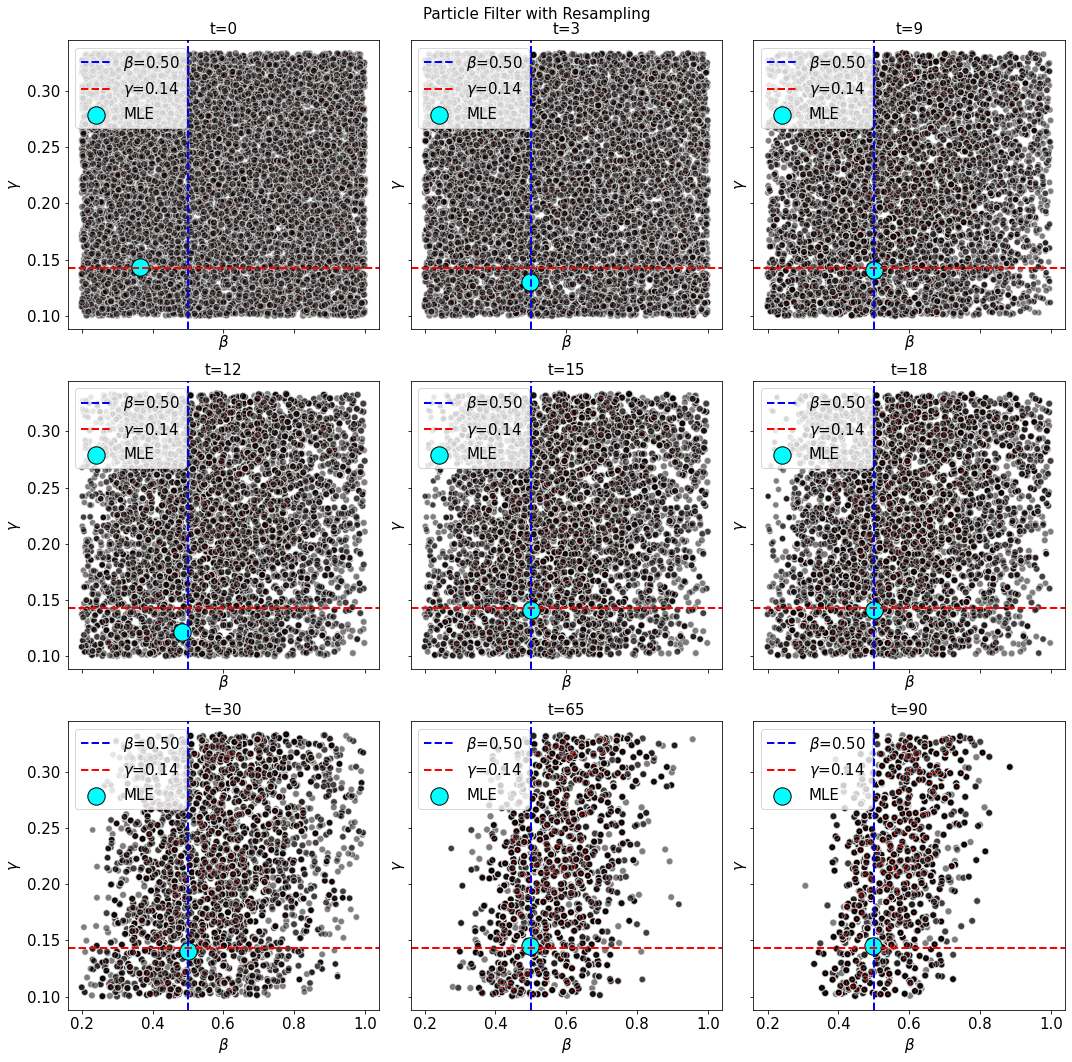

In [16]:
# Plot particle convergence just for ploting
particles_convergence = [0, 3, 9,
                        12, 15, 18,
                        30, 65, 90]

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
for idx, axi in enumerate(ax.flatten()):
    sizes = num_particles*weigths_all[:,particles_convergence[idx]]

    #sizes[idx_none] = None
    particles_time = particles_post_all[:,:,particles_convergence[idx]]


    #idx_color = np.where(sizes>1)[0]
    #particles_color = particles_time[idx_color]

    axi.scatter(particles_time[0,:], particles_time[1,:], edgecolor="w", facecolor="k", s=50*sizes, alpha=0.5)
    axi.scatter(particles_time[0,:], particles_time[1,:], edgecolor="red", facecolor="red", s=20*sizes/num_particles)

    particles_best_time = particles_time[:,weigths_all[:,particles_convergence[idx]].argmax()]
    axi.scatter(particles_best_time[0], particles_best_time[1], edgecolor="k", facecolor="cyan", s=300, label="MLE")

    axi.set_ylabel(r"$\gamma$", fontsize=15)
    axi.set_xlabel(r"$\beta$", fontsize=15)
    axi.set_title(f"t={particles_convergence[idx]}", fontsize=15)
    axi.axvline(x=beta_truth, color="blue", lw=2, linestyle="--", label=r"$\beta$={:0.2f}".format(beta_truth))
    axi.axhline(y=gamma_truth, color="r", lw=2, linestyle="--", label=r"$\gamma$={:0.2f}".format(gamma_truth))
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.legend(fontsize=15, loc="upper left")

fig.suptitle("Particle Filter with Resampling", fontsize=15)
plt.tight_layout()



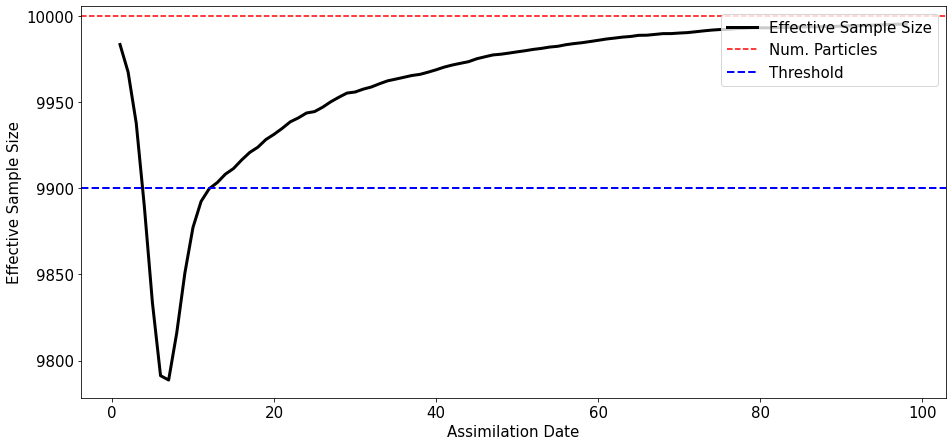

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

ax.plot(dates[1:], n_eff[1:], color="k", lw=3, label="Effective Sample Size")
ax.axhline(y=num_particles, color="red", linestyle="--", label="Num. Particles",)
ax.axhline(y=num_particles-num_particles/100, color="blue", linestyle="--", label="Threshold", lw=2)

ax.tick_params( which='both', axis='both', labelsize=15)
ax.set_ylabel("Effective Sample Size", fontsize=15)
ax.set_xlabel("Assimilation Date",     fontsize=15)
ax.legend(fontsize=15, loc="upper right")


In [18]:
best_particle = np.argmax(weigths_all[:,-1])

beta_best     = particles_post_all[0, best_particle, -1]
gamma_best    = particles_post_all[1, best_particle, -1]

# Simulate the model with best estimated parameters
N = 1e6
num_days = 100
x  = [N-0.01*N, 0.01*N, 0, 0]

num_iters =  num_particles

x_mle_df = pd.DataFrame(columns=["S", "I", "R", "C", "iter_idx"])

x_sol          = np.zeros((4, num_days, int(num_iters)))
x_sol[ :, 0, :] = np.expand_dims(x, -1) * np.ones((1, int(num_iters)))

# PARTICLE FILTER WITH IMPORTANCE SAMPLING
for idx_date, date in tqdm(enumerate(dates[1:])):
    particles_post = particles_prior.copy()
    # Integrate all particles.
    for idx_ens in range(num_particles):
        beta                          = particles_prior[0, best_particle]
        gamma                         = particles_prior[1, best_particle]
        x_sol[:, idx_date+1, idx_ens] = model(x_sol[:, idx_date, idx_ens], beta_best, gamma_best, N=1e6)



99it [00:16,  5.94it/s]


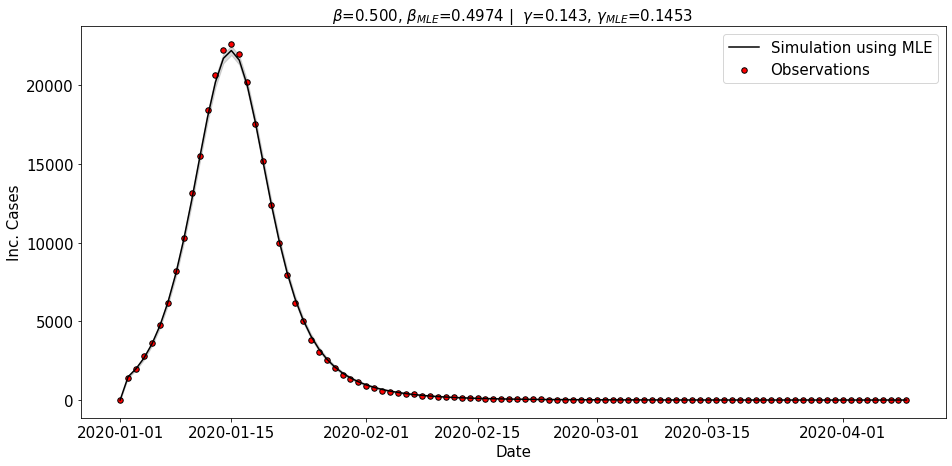

In [19]:
x_mle_df = pd.DataFrame(x_sol.T.reshape(len(dates) * num_particles, 4),columns=["S", "I", "R", "C"])

x_mle_df["date"]     = list(range(len(dates)))*num_iters
x_mle_df["iter_idx"] = flatten_list([[d]*len(dates) for d in list(range(num_iters)) ])
x_mle_df = x_mle_df.sort_values(by=[ "iter_idx", "date"])

sus_df = create_df_response(x_sol[0,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inf_df = create_df_response(x_sol[1,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
rec_df = create_df_response(x_sol[2,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inc_df = create_df_response(x_sol[3,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

ax.plot(inc_df.index.values, inc_df["mean"], color="k", label="Simulation using MLE")
ax.fill_between(inc_df.index.values, inc_df["low_95"], inc_df["high_95"], color="gray", alpha=0.3)

ax.scatter(inc_df.index.values, x_sol_df["C"], edgecolor="k", facecolor="red", label="Observations", s=30)
ax.tick_params( which='both', axis='both', labelsize=15)
ax.set_ylabel("Inc. Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_title(r"$\beta$={:0.3f}, $\beta_{{MLE}}$={:0.4f} |  $\gamma$={:0.3f}, $\gamma_{{MLE}}$={:0.4f} ".format(beta_truth, beta_best, gamma_truth, gamma_best), fontsize=15)
ax.legend(fontsize=15)


## Compare Particle Filter with Importance Sampling and with Resampling.


# Particle Filter with Proposal Density